# SENTIMENTAL ANALYSIS

## Dataset

### Dependencies

In [1]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
  basepath = r"datasets\amazon-5-core"
  df = getDF(os.path.join(basepath, dataset))
  return df
  
def download_dataset(dataset):
  request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
  request.add_header('Accept-encoding', 'gzip')
  response = urllib.request.urlopen(request)
  buf = io.BytesIO(response.read())
  file = gzip.GzipFile(fileobj=buf)
  df = []
  for line in file:
    df.append(eval(line))
  return pd.DataFrame(df)

Reading from JSON

In [3]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

Wall time: 1min 22s


###  Description

#### Schema

In [4]:
print("(rows, cols) = ", dfull.shape)

(rows, cols) =  (278677, 9)


In [5]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [6]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   userID          278677 non-null  object 
 1   productID       278677 non-null  object 
 2   userName        278225 non-null  object 
 3   helpful         278677 non-null  object 
 4   text            278677 non-null  object 
 5   rating          278677 non-null  float64
 6   summary         278677 non-null  object 
 7   unixReviewTime  278677 non-null  int64  
 8   reviewTime      278677 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [7]:
dfull.head(3)

,userID,productID,userName,helpful,text,rating,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"


#### Columns analysis

##### Users and products

In [8]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Average REVIEWS PER USER: ", rows/n_users)
print("Average REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  278677
Number of USERS:  39387
Number of PRODUCTS:  23033
Average REVIEWS PER USER:  7.075354812501587
Average REVIEWS PER PRODUCT:  12.099031823904832


##### Rating

In [9]:
print("Average rating: ", dfull['rating'].mean())

Average rating:  4.245133254628118


Rating distribution


<AxesSubplot:>

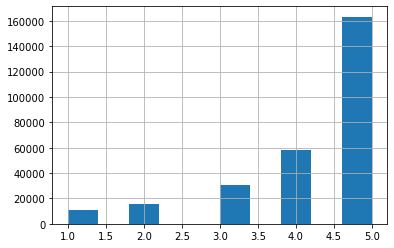

In [10]:
print("Rating distribution")
dfull['rating'].hist()

#### Droping columns

In [11]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName'], axis = 1)

#### Binarization

In [12]:
dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]

print("Sentiment count")
dfull['sentiment'].value_counts()

Sentiment count


positive    221597
negative     57080
Name: sentiment, dtype: int64

***

## Sentiment Analysis

### Dependencies

In [13]:
!pip install wordcloud

In [14]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')


from PIL import Image
from wordcloud import WordCloud

import collections
import itertools


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text pre-processing

#### Tokenization

Default tokenizers have weird behaviour with puntctuation, numbers etc

In [15]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\d\W][\w\']*') # preserve alphabetic words (not numbers) and contractions

#### Stopwords removing


In [16]:
#stopset = set(stopwords.words('english')) # too aggressive

stopset = {
    'one',
    'a', 'ain', 'and', 'any', 'are', 'as', 'at', 
    'be', 'because', 'being', 'between', 'both', 'by', 
    'doing', 'during', 'each', 'few', 'for', 'from', 'further', 
    'has', 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 
    'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 
    'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'my', 'myself', 
    'now', 'o', 'of', 'off', 'on', 'once', 'or', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 
    're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'so', 'some', 'such', 
    't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 
    'there', 'these', 'they', 'this', 'those', 'through', 'to', 'until', 'up', 've', 
    'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'with', 
    'y', 'you', "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'}

print("Stopwords (%.0f): " % len(stopset), list(stopset))

Stopwords (116):  ['you', 'same', 'be', 'him', 'as', 'have', 'their', 'both', 'any', 'those', 'of', 'into', 'by', 'its', 'on', 'one', 'this', "you've", "it's", 'theirs', 'ain', 'being', 'from', 'she', 're', 'me', 'themselves', 'i', 'than', 'herself', 'll', "that'll", 'doing', 'for', 'each', 'hers', 'in', 'until', 'your', 'are', "she's", 'or', 'here', 'they', 'has', 've', 'over', 'which', 'the', 'he', 'once', 'was', 'is', 'ma', 'up', 'whom', 'few', 'having', 'and', 'why', 'out', 'through', 'haven', 'myself', 'itself', 'his', 'm', 'there', 'while', 'them', 'ours', 'shan', 'at', 'himself', 'were', 'to', 'so', 'our', 'just', 'then', 'a', 'who', 'y', 'it', 'yourself', 'we', 'her', 'how', 'when', 'my', 't', 'yourselves', 'off', 's', 'should', 'yours', 'where', "should've", 'with', 'own', "shan't", 'because', 'further', 'if', "you're", 'between', "haven't", 'some', 'during', 'such', 'what', 'now', 'these', 'o', 'that', 'ourselves']


#### Stemming

In [17]:
stemmer = SnowballStemmer('english')

#### Full example

In [18]:
print("TEXT ANALYSIS EXAMPLE")

text = "Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case."
print("Text:\t\t", text) # original

# tokenizing
tokens = tokenizer.tokenize(text)
print("Tokenized:\t", tokens)

# # lowercasing
# tokens = [t.lower() for t in tokens] 
# print("Lowercased:\t", tokens)

# removing stopwords
tokens = [t for t in tokens if not t in stopset]  
print("No stopwords:\t", tokens)

# stemming
tokens = [stemmer.stem(t) for t in tokens]
print("Stemmed:\t", tokens)

TEXT ANALYSIS EXAMPLE
Text:		 Hi! This... isn't a beautiful sentence with some interesting $70 and €5,50 features like people's names and Mr. Fox thoughts for number such as 23, 4 and 7 or peer2peer and wi-fi with snake_case but not kebab-case.
Tokenized:	 ['Hi', 'This', "isn't", 'a', 'beautiful', 'sentence', 'with', 'some', 'interesting', 'and', 'features', 'like', "people's", 'names', 'and', 'Mr', 'Fox', 'thoughts', 'for', 'number', 'such', 'as', 'and', 'or', 'peer2peer', 'and', 'wi', 'fi', 'with', 'snake_case', 'but', 'not', 'kebab', 'case']
No stopwords:	 ['Hi', 'This', "isn't", 'beautiful', 'sentence', 'interesting', 'features', 'like', "people's", 'names', 'Mr', 'Fox', 'thoughts', 'number', 'peer2peer', 'wi', 'fi', 'snake_case', 'but', 'not', 'kebab', 'case']
Stemmed:	 ['hi', 'this', "isn't", 'beauti', 'sentenc', 'interest', 'featur', 'like', 'peopl', 'name', 'mr', 'fox', 'thought', 'number', 'peer2peer', 'wi', 'fi', 'snake_cas', 'but', 'not', 'kebab', 'case']


#### Processing dataset

In [19]:
def text_processing(field):
  normalized = dfull[field]
  normalized = normalized.apply(tokenizer.tokenize)
  normalized = normalized.apply(lambda tokens_list: [token for token in tokens_list])
  normalized = normalized.apply(lambda tokens_list: [token for token in tokens_list if token not in stopset])
  #normalized = normalized.apply(lambda tokens_list: [stemmer.stem(token) for token in tokens_list])
  return normalized

In [20]:
predictions_field = 'text'
%time tokenized_fields = text_processing(predictions_field)

Wall time: 23.6 s


In [21]:
dfull[predictions_field + '_tokens'] = tokenized_fields
dfull[predictions_field + '_normalized'] = tokenized_fields.apply(lambda tokens_list: ' '.join(tokens_list))

pd.set_option('display.max_columns', 150)
dfull.head(3)

,userID,productID,text,rating,summary,sentiment,text_tokens,text_normalized
0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,positive,"[This, great, tutu, really, great, price, It, ...",This great tutu really great price It doesn't ...
1,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,positive,"[I, bought, yr, old, daughter, dance, class, w...",I bought yr old daughter dance class wore toda...
2,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...,5.0,I have buy more than one,positive,"[What, can, I, say, daughters, orange, black, ...",What can I say daughters orange black white pi...


### Undersampling


In [22]:
from sklearn.utils import *

# Separate majority and minority classes
positive_count = dfull['sentiment'].value_counts()['positive']
negative_count = dfull['sentiment'].value_counts()['negative']
df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# Downsample majority class
obj_samples = negative_count if positive_count >= negative_count else positive_count
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples = obj_samples, # match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
ddown = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("Positive/negative distribution post-undersampling")
ddown['sentiment'].value_counts()

Positive/negative distribution post-undersampling


negative    57080
positive    57080
Name: sentiment, dtype: int64

### Most common words

#### All reviews

Text(0.5, 1.0, 'Most common words in ALL reviews')

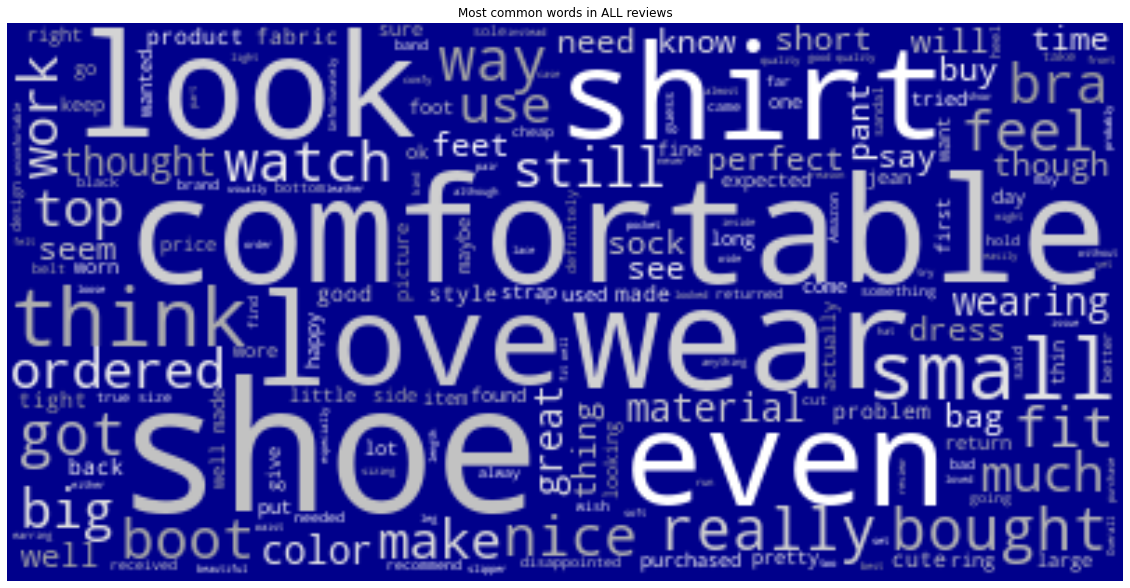

In [23]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

  
all_tokenlist = ddown[predictions_field + '_tokens']
sentences = (list(itertools.chain(all_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="darkblue").generate(" ".join(flat_list))
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in ALL reviews")



---



#### Positive reviews

Text(0.5, 1.0, 'Most common words in POSITIVE reviews')

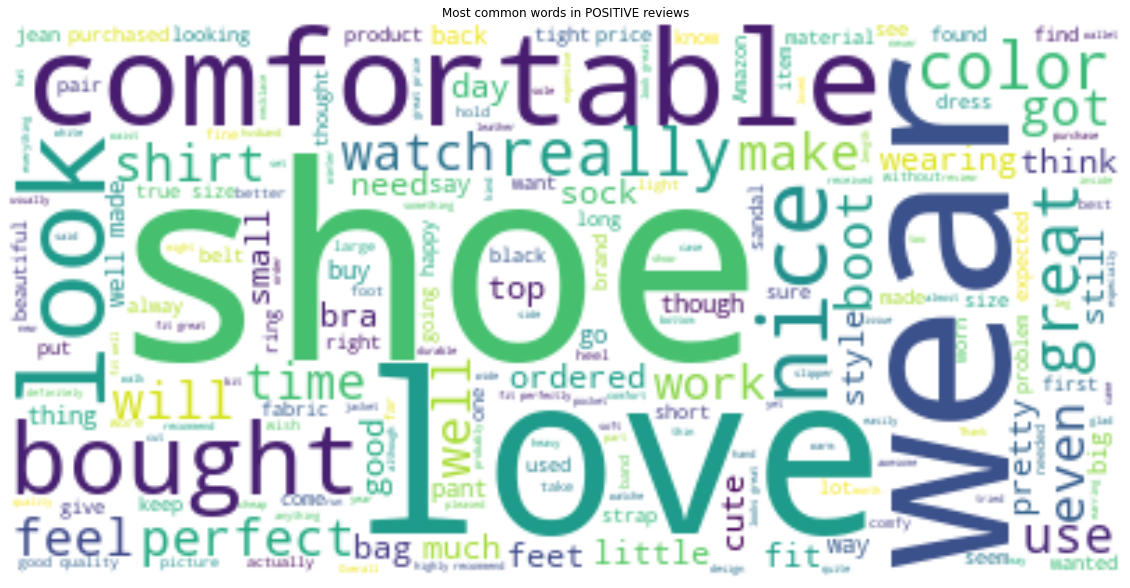

In [24]:
positive_tokenlist = ddown[ddown['sentiment'] == 'positive'][predictions_field + '_tokens']
sentences = (list(itertools.chain(positive_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="white").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in POSITIVE reviews")

#### Negative reviews

Text(0.5, 1.0, 'Most common words in NEGATIVE reviews')

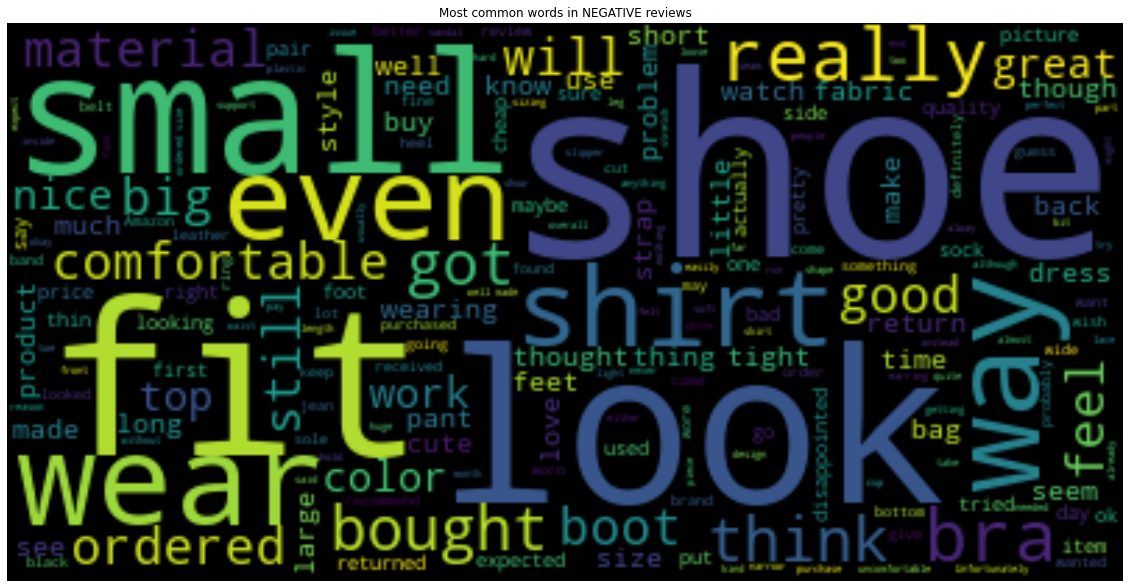

In [25]:
positive_tokenlist = ddown[ddown['sentiment'] == 'negative'][predictions_field + '_tokens']
sentences = (list(itertools.chain(positive_tokenlist)))
flat_list = [item for sublist in sentences for item in sublist]

fig = plt.figure(figsize=(20,14))
wordcloud = WordCloud(background_color="black").generate(" ".join(flat_list))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in NEGATIVE reviews")

## Machine Learning

### TF-IDF (term frequency - inverse document frequency)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

ddown = ddown.drop(['rating'], axis = 1, errors = 'ignore') # directly infers sentiment

ddown['sentiment'] = [1 if s == 'positive' else 0 for s in ddown['sentiment']] # needed 0-1 by sklearn for k-fold cv


# Tf-idf settings
tvec = TfidfVectorizer(use_idf = True,
                       strip_accents = None, # already done
                       stop_words = None, # already done
                       lowercase = False) # already done

actuals = ddown.sentiment # truth
tfidf = tvec.fit_transform(ddown[predictions_field + '_normalized']) # learning vocabulary and idf

print("(rows,) \t=", actuals.shape) # truth
print("(rows, terms)\t=", tfidf.shape) # Tf-idf-weighted document-term matrix

(rows,) 	= (114160,)
(rows, terms)	= (114160, 61923)


### Term Weights

Common terms have higher weights in the resulting Tf-idf-weighted document-term matrix.

In [27]:
print("Most weighted terms")
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

Most weighted terms


,term,weight
25995,but,0.035008
44190,not,0.030788
18610,The,0.026405
59686,very,0.026297
52577,size,0.025857
40902,like,0.024388
34364,fit,0.022917
9299,It,0.022412
60417,wear,0.021731
57480,too,0.020114


### Splitting training and test set


In [28]:
from sklearn.model_selection import train_test_split

tfidf_train, tfidf_test, actuals_train, actuals_test = train_test_split(tfidf, actuals, test_size = 0.3, shuffle = True)

### Models

Several machine learning models will be tried out to predict `rating` 

In [29]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer

from sklearn import naive_bayes
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier



def roc_and_auc(model):  
  
  pred_probs = model.predict_proba(tfidf_test)[:,1] # prediction probabilities for positive class
  
  auc = metrics.roc_auc_score(actuals_test, pred_probs)
  
  fpr, tpr, thresholds = metrics.roc_curve(actuals_test, pred_probs, pos_label = 1)
  plt.figure()
  plt.plot(fpr, tpr, label = 'AUROC = %0.4f' % auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.title('ROC Curve')
    

    
    
def run_model(model, folds = 10):
  
  print(model)
  print()
  
  # LEARNING AND PREDICTION
  
  model.fit(tfidf_train, actuals_train)
  predictions = model.predict(tfidf_test)
  
  
  # CONFUSION MATRIX
  
  df_confusion = pd.crosstab(actuals_test, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
  print("Confusion matrix\n", df_confusion)
  
  cm = metrics.confusion_matrix(actuals_test, predictions)
  plt.matshow(cm)
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  
  print("\n METRICS")
  print(metrics.classification_report(actuals_test, predictions))
  
  
  # ROC/AUC
  roc_and_auc(model)
  
  
  # CROSS VALIDATION
  
  print()
  accuracy = cross_val_score(model, tfidf, actuals, cv=folds, scoring='accuracy')
  print("ACCURACY ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, accuracy.mean(), accuracy.std()))
  precision = cross_val_score(model, tfidf, actuals, cv=folds, scoring='precision')
  print("PRECISION ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, precision.mean(), precision.std()))
  recall = cross_val_score(model, tfidf, actuals, cv=folds, scoring='recall')
  print("RECALL ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, recall.mean(), recall.std()))
  f1 = cross_val_score(model, tfidf, actuals, cv=folds, scoring='f1')
  print("F1 ON %.0f FOLD CROSS VALIDATION: \t %0.4f (std deviation %0.6f)" % (folds, f1.mean(), f1.std()))
  
  print("\n")

#### Naive Bayes

MultinomialNB()

Confusion matrix
 Predicted      0      1    All
Actual                        
0          14489   2639  17128
1           3660  13460  17120
All        18149  16099  34248


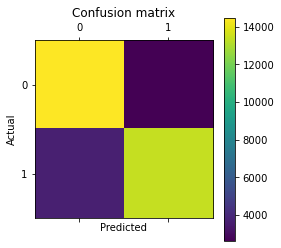


 METRICS
              precision    recall  f1-score   support

           0       0.80      0.85      0.82     17128
           1       0.84      0.79      0.81     17120

    accuracy                           0.82     34248
   macro avg       0.82      0.82      0.82     34248
weighted avg       0.82      0.82      0.82     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.8146 (std deviation 0.006010)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.8291 (std deviation 0.012510)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.7929 (std deviation 0.006173)
F1 ON 10 FOLD CROSS VALIDATION: 	 0.8105 (std deviation 0.004696)


Wall time: 8.14 s


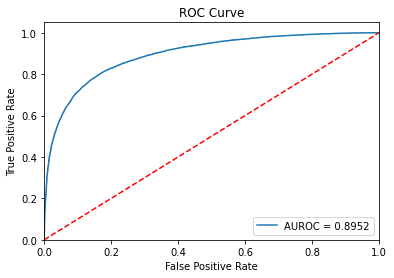

In [30]:
  bayes = naive_bayes.MultinomialNB()
  %time run_model(bayes)

#### SVM

SGDClassifier(loss='log')

Confusion matrix
 Predicted      0      1    All
Actual                        
0          14580   2548  17128
1           3262  13858  17120
All        17842  16406  34248


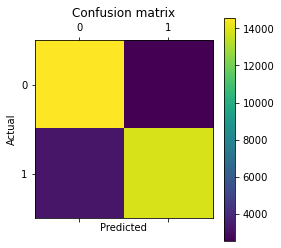


 METRICS
              precision    recall  f1-score   support

           0       0.82      0.85      0.83     17128
           1       0.84      0.81      0.83     17120

    accuracy                           0.83     34248
   macro avg       0.83      0.83      0.83     34248
weighted avg       0.83      0.83      0.83     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.8307 (std deviation 0.005084)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.8417 (std deviation 0.009006)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.8169 (std deviation 0.008712)
F1 ON 10 FOLD CROSS VALIDATION: 	 0.8284 (std deviation 0.004383)


Wall time: 33.8 s


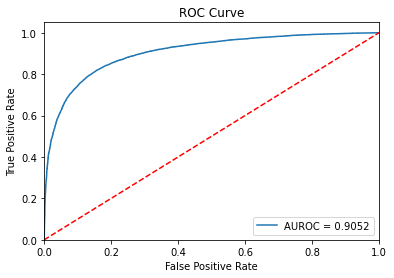

In [31]:
svm = SGDClassifier(loss='log')
%time run_model(svm)

#### Random Forest

Random Forest is slow and performs worse than the other models.

RandomForestClassifier(n_estimators=5)

Confusion matrix
 Predicted      0      1    All
Actual                        
0          12720   4408  17128
1           4932  12188  17120
All        17652  16596  34248


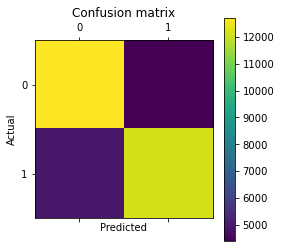


 METRICS
              precision    recall  f1-score   support

           0       0.72      0.74      0.73     17128
           1       0.73      0.71      0.72     17120

    accuracy                           0.73     34248
   macro avg       0.73      0.73      0.73     34248
weighted avg       0.73      0.73      0.73     34248


ACCURACY ON 10 FOLD CROSS VALIDATION: 	 0.7278 (std deviation 0.006616)
PRECISION ON 10 FOLD CROSS VALIDATION: 	 0.7346 (std deviation 0.009969)
RECALL ON 10 FOLD CROSS VALIDATION: 	 0.7132 (std deviation 0.010189)
F1 ON 10 FOLD CROSS VALIDATION: 	 0.7201 (std deviation 0.004243)


Wall time: 29min 18s


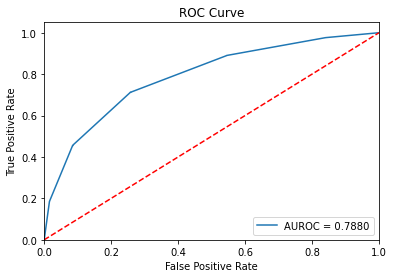

In [32]:
forest = RandomForestClassifier(n_estimators = 5) # default n_estimators is 10
%time run_model(forest, folds = 10)

### Prediction 

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

ddown = ddown.drop(['rating'], axis = 1, errors = 'ignore') # directly infers sentiment

# Tf-idf settings
text_clf = Pipeline([
  ('vect', TfidfVectorizer(use_idf = True,
#                    strip_accents = 'ascii',
                   stop_words = stopset,
                   lowercase = False)),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(loss='log')),
])

**Training**

In [34]:
from sklearn.model_selection import train_test_split

train, test, actuals_train, actuals_test = train_test_split(ddown[predictions_field], ddown.sentiment, test_size = 0.3, shuffle = True)

text_clf.fit(train, actuals_train)
predicted = text_clf.predict(test)

print('Accuracy', np.mean(predicted == actuals_test))

Accuracy 0.838326325624854


In [35]:
text_clf.predict(['bad kitchen sold on amazon', 'this camera is pretty great', 'Great service ever', 'not as good as expected'])

array([0, 1, 1, 0], dtype=int64)

#### Saving model

In [36]:
import pickle

pickle.dump(text_clf, open('sentiment_model.pkl', 'wb'))

In [38]:
model = pickle.load(open('sentiment_model.pkl','rb'))
print(model.predict(["Nice Product"]))

[1]


In [39]:
# from google.colab import drive
# from joblib import dump, load

# drive.mount('/content/drive')
# drivepath = '/content/drive/My Drive/Data Analytics/'

# dump(text_clf, drivepath + 'model.joblib')

---

## Conclusions

Overall, Naive Bayes and SVM act very well among all tested datasets. Random Forest is slower and even worse in results, so it might not be recommendable for Reviews Sentiment Analysis.
